In [915]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.interpolate import griddata
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV

In [916]:
#Load the data
SensorData = pd.read_csv('data/raw/BCIsensor_xy.csv',header=None)
Img_data_1 = pd.read_csv('data/raw/feaSubEImg_1.csv',header=None)
Img_data_2 = pd.read_csv('data/raw/feaSubEImg_2.csv',header=None)
Overt_data_1 = pd.read_csv('data/raw/feaSubEOvert_1.csv',header=None)
Overt_data_2 = pd.read_csv('data/raw/feaSubEOvert_2.csv',header=None)

In [917]:
#number of rows and columns in each dataset
print(SensorData.shape)
print(Img_data_1.shape)
print(Img_data_2.shape)
print(Overt_data_1.shape)
print(Overt_data_2.shape)


(102, 2)
(204, 120)
(204, 120)
(204, 120)
(204, 120)


In [918]:
def plot_electrode_positions(data):
    x_coords = data[0]
    y_coords = data[1]
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    plt.scatter(x_coords, y_coords, color='blue')  # Plots the electrode positions as blue dots
    for i in range(data.shape[1] - 1):
        plt.plot([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]], color='purple')  # Connects with lines

    # Annotating specific electrodes
    annotations = [0, 53, 54, 101]  # Example based on your previous image
    for annotation in annotations:
        plt.text(x_coords[annotation], y_coords[annotation], str(annotation+1), color='black')

    # Additional plot settings
    plt.title('Electrode Positions')
    plt.axis('off')  # Hide axis
    plt.show()

In [919]:
def svm_classifier(X_train, y_train, X_test, y_test, lambda_val):
    C = 1 / lambda_val
    clf = SVC(kernel='linear', C=C,max_iter= 50000)
    clf.fit(X_train, y_train)
    try:
        channel_weights = clf.coef_[0]
    except:
        channel_weights = np.arange(204)
    y_hat = clf.predict(X_test)
    #accuracy = (y_hat == y_test).sum() / len(y_test)
    accuracy = accuracy_score(y_test, y_hat)
    decision_statistics = clf.decision_function(X_test)
    return accuracy, channel_weights, decision_statistics, len(clf.support_vectors_)

In [920]:
def find_best_ridge_lambda(X_train, y_train, alphas):
    ridge = RidgeCV(alphas=alphas, store_cv_values=True)
    ridge.fit(X_train, y_train)
    best_alpha = ridge.alpha_
    return best_alpha

In [921]:
def cross_validation_one_level(data, labels, test_data, test_labels, alphas, num_folds=5):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    validation_scores = []

    # Cross-validate within the training set to find the best alpha
    for train_index, val_index in kf.split(data, labels):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        
        # Compute the best alpha using ridge regression on the fold
        best_alpha = find_best_ridge_lambda(X_train, y_train, alphas)
        
        # Evaluate the SVM classifier with the found best alpha on the validation fold
        _, _, val_statistics,_ = svm_classifier(X_train, y_train, X_val, y_val, best_alpha)
        val_accuracy = accuracy_score(y_val, val_statistics > 0)  # Assuming decision function threshold at 0
        validation_scores.append(val_accuracy)

    # Average the validation accuracies to decide on the final best alpha
    best_alpha = alphas[np.argmax(validation_scores)]

    # Now train and evaluate the classifier on the entire train set and test set respectively with the best alpha
    test_accuracy, channel_weights, decision_statistics,_ = svm_classifier(data, labels, test_data, test_labels, best_alpha)

    return test_accuracy, channel_weights, decision_statistics, best_alpha

In [922]:
def two_level_cross_validation(data, labels, lambda_val_list, num_outer_folds=6, num_inner_folds=5):
    outer_kf = StratifiedKFold(n_splits=num_outer_folds, shuffle=True,random_state=42)
    roc_aucs = []
    accuracies = []
    all_channel_weights = []

    # First level cross-validation (outer loop)
    for fold_num, (train_index, test_index) in enumerate(outer_kf.split(data,labels),1):
        # Splitting data into training and hold-out test set for this fold
        outer_train_data, outer_test_data = data[train_index], data[test_index]
        outer_train_labels, outer_test_labels = labels[train_index], labels[test_index]

        # Second level cross-validation (inner loop)
        # Here you perform one-level cross-validation on the training data to find the best lambda
        test_accuracy, channel_weights, decision_statistics, best_lambda_val = cross_validation_one_level(
            outer_train_data, outer_train_labels, outer_test_data, outer_test_labels, 
            alphas=lambda_val_list
        )
        # Store channel weights
        all_channel_weights.append(channel_weights)
        # Calculate the ROC AUC for the held-out test set
        fpr, tpr, _ = roc_curve(outer_test_labels, decision_statistics)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        accuracies.append(test_accuracy)

        # Optionally, plot the ROC curve for this fold
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold_num} ROC curve (area = {roc_auc:.2f})')

    # Calculate the average ROC AUC and accuracy
    average_roc_auc = np.mean(roc_aucs)
    average_accuracy = np.mean(accuracies)
    roc_auc_variance = np.var(roc_aucs)
    accuracy_variance = np.var(accuracies)

    # Plot the chance line
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Return the average metrics and their variances
    return average_roc_auc, average_accuracy, roc_auc_variance, accuracy_variance, all_channel_weights

In [923]:
def two_level_cross_validation(data, labels, lambda_val_list, num_outer_folds=6, num_inner_folds=5):
    outer_kf = StratifiedKFold(n_splits=num_outer_folds, shuffle=True, random_state=42)
    roc_aucs = []
    accuracies = []
    all_channel_weights = []
    all_fpr = np.linspace(0, 1, 100)  # Define a common set of FPR thresholds for interpolation
    best_lambda_vals = []

    mean_tpr = 0.0  # To accumulate the mean TPR at each FPR threshold

    # First level cross-validation (outer loop)
    for fold_num, (train_index, test_index) in enumerate(outer_kf.split(data, labels), 1):
        # Splitting data into training and hold-out test set for this fold
        outer_train_data, outer_test_data = data[train_index], data[test_index]
        outer_train_labels, outer_test_labels = labels[train_index], labels[test_index]

        # Second level cross-validation (inner loop)
        test_accuracy, channel_weights, decision_statistics, best_lambda_val = cross_validation_one_level(
            outer_train_data, outer_train_labels, outer_test_data, outer_test_labels, 
            alphas=lambda_val_list
        )
        all_channel_weights.append(channel_weights)
        fpr, tpr, _ = roc_curve(outer_test_labels, decision_statistics)
        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        accuracies.append(test_accuracy)
        best_lambda_vals.append(best_lambda_val)

        # Interpolate each fold's TPR based on the common FPR
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        mean_tpr[0] = 0.0  # Ensuring the TPR starts from zero

        # Plot individual ROC curves for each fold
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold_num} ROC curve (area = {roc_auc:.2f})')

    # Finalize the mean TPR and compute the mean AUC
    mean_tpr /= num_outer_folds
    mean_tpr[-1] = 1.0  # Ensuring the TPR ends at one
    mean_auc = auc(all_fpr, mean_tpr)

    # Plot the average ROC curve
    plt.plot(all_fpr, mean_tpr, color='black', linestyle='-', lw=2, label=f'Mean ROC (area = {mean_auc:.2f})')

    # Plot the chance line
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print('accuracy:', accuracies)
    print('best lambda:', best_lambda_vals)

    # Return the average metrics and their variances
    return mean_auc, np.mean(accuracies), np.var(roc_aucs), np.var(accuracies), all_channel_weights

In [924]:
def plot_roc_curve(y_test, decision_statistics,plot_title):
    fpr, tpr, thresholds = roc_curve(y_test, decision_statistics)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.show()

In [925]:
def show_channel_weights(channel_weights_x, channel_weights_y, plot_title='Channel Weights Plotted on Brain Surface'):
    # Combine x and y weights to get the magnitude for each electrode
    channel_weights_magnitude = np.sqrt(channel_weights_x**2 + channel_weights_y**2)
    
    # Assuming SensorData is loaded and contains the x, y coordinates of the electrodes
    # And that it has been sorted in the same order as the weights
    x = SensorData.iloc[:, 0].values
    y = SensorData.iloc[:, 1].values
    
    xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate the weights onto the grid using cubic interpolation
    zi = griddata((x, y), channel_weights_magnitude, (xi, yi), method='cubic')

    # Visualize using pcolor
    plt.figure()
    plt.pcolor(xi, yi, zi, cmap='jet')
    plt.colorbar(label='Weight Magnitude')
    #plt.scatter(x, y, c='k', s=5)  # Optionally, plot the original electrode positions
    plt.axis('equal')
    plt.axis('off')
    plt.title(plot_title)
    plt.show()

In [926]:
def show_channel_weights_heatmap(channel_weights_x, channel_weights_y, SensorData, plot_title='Channel Weights Heatmap on Brain Surface'):
    x = SensorData.iloc[:, 0].values
    y = SensorData.iloc[:, 1].values
    channel_weights_magnitude = np.sqrt(channel_weights_x**2 + channel_weights_y**2)

    # Interpolate the magnitudes onto a regular grid covering the convex hull of the electrode positions
    grid_x, grid_y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    grid_z = griddata((x, y), channel_weights_magnitude, (grid_x, grid_y), method='cubic')

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(grid_z.T, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='jet', interpolation='nearest')
    plt.colorbar(label='EEG signal magnitude')
    plt.title('EEG Data Heatmap')
    plt.show()

In [927]:
def stemplot_channel_weights(channel_weights, plot_title='Channel Weights'):
    plt.figure(figsize=(10, 5))
   # Sort weights by absolute value and get indices of six largest:
    dominant_indices = np.argsort(np.abs(channel_weights))[-6:]

    #PRINTING THE DOMINANT INDICES WITH THEIR WEIGHTS
    print("Dominant Indices with their weights")
    for i in dominant_indices:
        print(f"Index: {i}, Weight: {channel_weights[i]}")

    # Create a basic stem plot without the use_line_collection argument
    (markerline, stemlines, baseline) =plt.stem(range(len(channel_weights)), channel_weights, linefmt='blue', markerfmt= 'bo' , basefmt='r-')

    plt.setp(stemlines, 'linewidth', 0.5)  # Making the stem lines thinner
    plt.setp(markerline, 'color', 'blue')  # Making the markers blue
    plt.setp(baseline, 'color', 'blue', 'linewidth', 0.5)  # Making the baseline red and thinner

    # Overlay the dominant magnitudes with a different color:
    plt.stem(dominant_indices, channel_weights[dominant_indices], 'r', markerfmt='ro', basefmt='r-')

    # Set plot titles and labels:
    plt.title(plot_title)
    plt.xlabel('Electrode Index')
    plt.ylabel('Weight')

In [928]:
def run_svm(data1, data2):
    X = np.concatenate((data1.T, data2.T))
    y = np.array([0]*len(data1.T) + [1]*len(data2.T))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    accuracy, channel_weights, decision_statistics, num_support_vectors = svm_classifier(X_train, y_train, X_test, y_test,100)
    # Display the results
    print("Accuracy:", accuracy)
    print("Number of Support Vectors:", num_support_vectors)
    print("Decision Statistics for all test samples:", decision_statistics)
    return y_test, decision_statistics,channel_weights

# Simulations

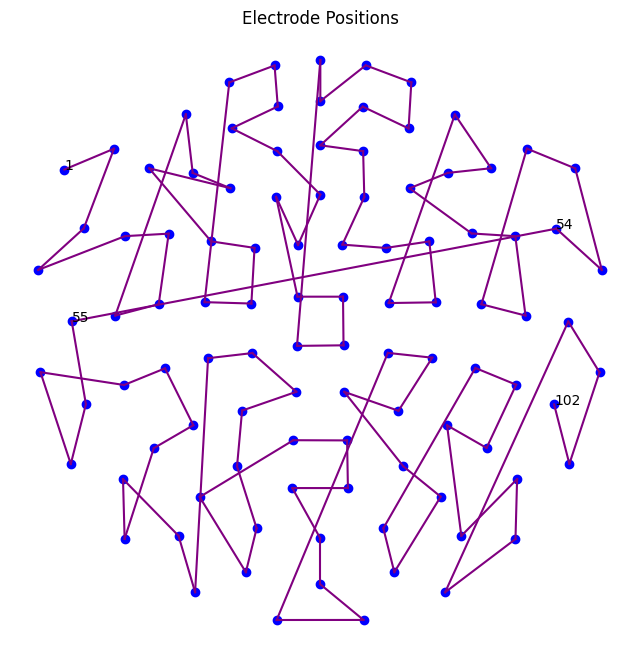

In [929]:
plot_electrode_positions(SensorData.values.T)

### Imagined Movement Data

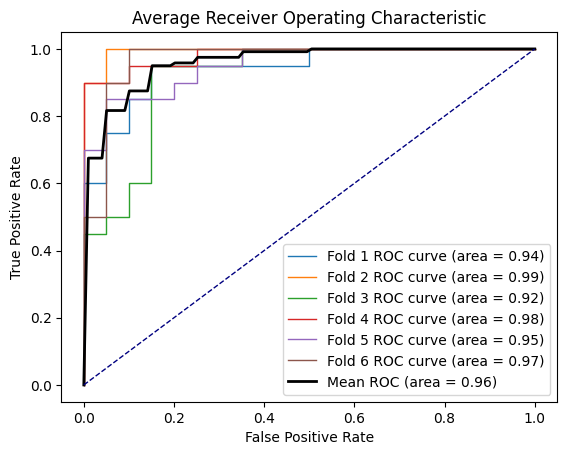

accuracy: [0.9, 0.925, 0.825, 0.925, 0.825, 0.9]
best lambda: [0.021209508879201904, 0.012067926406393288, 0.01, 0.01, 0.017575106248547922, 0.01]
Average ROC AUC: 0.9578282828282829 ± 0.00
Average Accuracy: 0.8833333333333334 ± 0.00


/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_49870/2706776590.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Weight Magnitude')


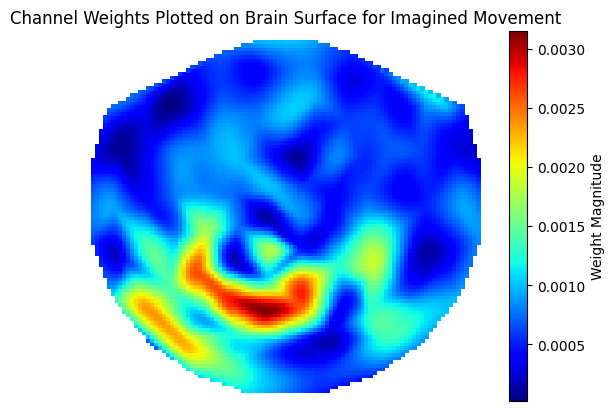

Dominant Indices with their weights
Index: 126, Weight: -0.0019913005961569785
Index: 155, Weight: -0.002033595559135279
Index: 140, Weight: 0.0021038334778108927
Index: 153, Weight: 0.0021078045876130624
Index: 128, Weight: -0.0024550664930735873
Index: 151, Weight: 0.002461447052314055


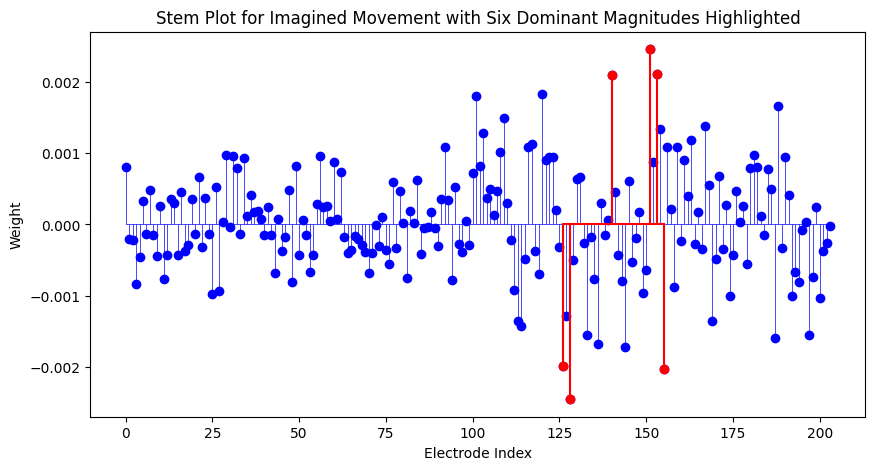

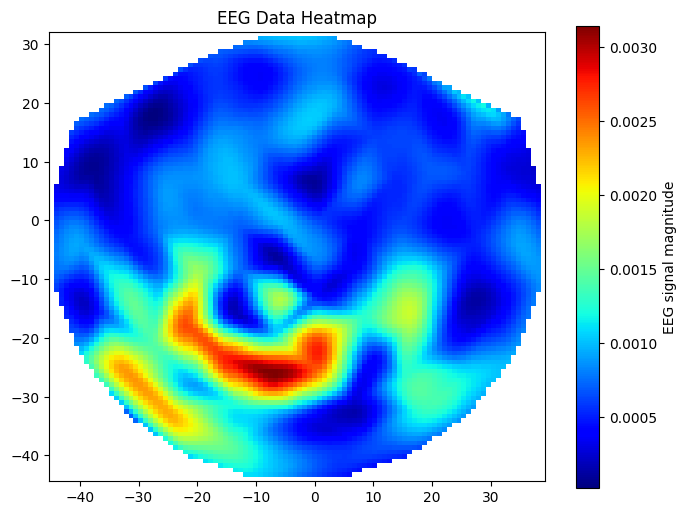

In [930]:
X = np.concatenate((Img_data_1.T, Img_data_2.T))
y = np.array([0]*len(Img_data_1.T) + [1]*len(Img_data_2.T))
lambda_val_list = np.logspace(-2, 2, num=50)
average_roc_auc, average_accuracy, roc_auc_variance, accuracy_variance,channel_weights = two_level_cross_validation(X, y, lambda_val_list)
print(f'Average ROC AUC: {average_roc_auc} ± {roc_auc_variance:.2f}')
print(f'Average Accuracy: {average_accuracy} ± {accuracy_variance:.2f}')

channel_weights_mean = np.mean(channel_weights, axis=0)
channel_weights_x = channel_weights_mean[::2]
channel_weights_y = channel_weights_mean[1::2]
show_channel_weights(channel_weights_x, channel_weights_y, 'Channel Weights Plotted on Brain Surface for Imagined Movement')
#channel_weights of only one fold
stemplot_channel_weights(channel_weights[0],'Stem Plot for Imagined Movement with Six Dominant Magnitudes Highlighted')
show_channel_weights_heatmap(channel_weights_x, channel_weights_y, SensorData)


### Overt Movement Data

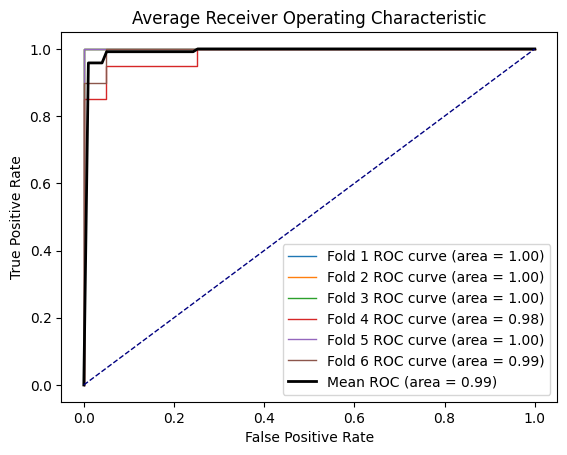

accuracy: [0.975, 0.975, 0.975, 0.95, 0.95, 0.975]
best lambda: [1, 100, 1, 0.01, 0.01, 0.01]
Average ROC AUC: 0.9915824915824916 ± 0.00
Average Accuracy: 0.9666666666666667 ± 0.00


/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_49870/2706776590.py:19: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Weight Magnitude')


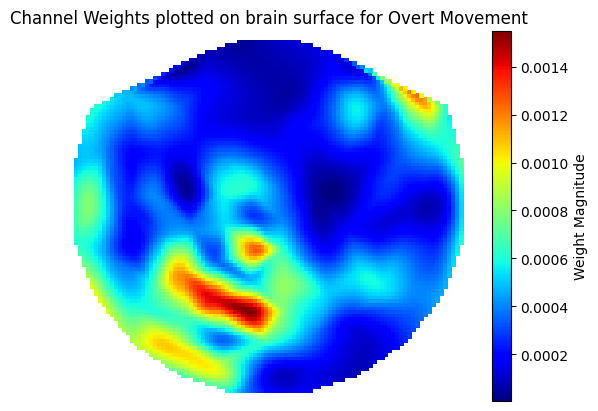

Dominant Indices with their weights
Index: 128, Weight: -0.0010586073617156228
Index: 155, Weight: -0.0010665924028851136
Index: 154, Weight: 0.0011011281477370303
Index: 136, Weight: -0.001115914248844571
Index: 100, Weight: 0.001158541408288346
Index: 140, Weight: 0.0013838703073457577


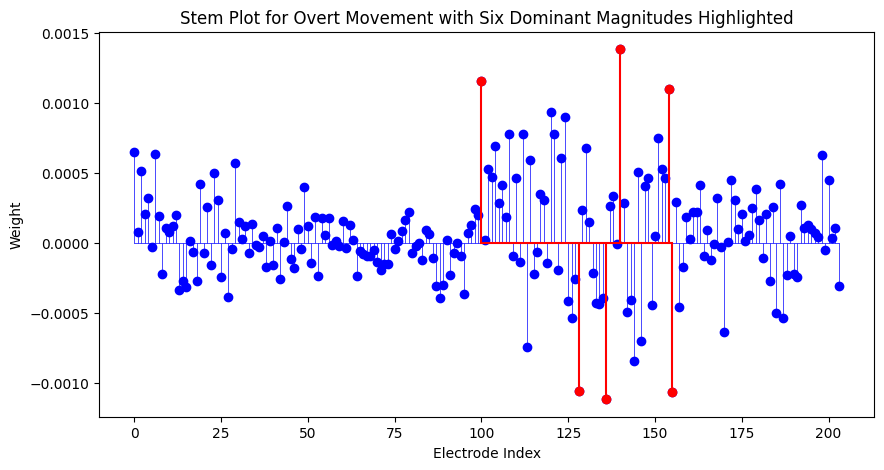

In [931]:
X = np.concatenate((Overt_data_1.T, Overt_data_2.T))
y = np.array([0]*len(Overt_data_1.T) + [1]*len(Overt_data_2.T))
lambda_val_list = [0.01, 1, 100, 10000]
average_roc_auc, average_accuracy, roc_auc_variance, accuracy_variance,channel_weights = two_level_cross_validation(X, y, lambda_val_list)
print(f'Average ROC AUC: {average_roc_auc} ± {roc_auc_variance:.2f}')
print(f'Average Accuracy: {average_accuracy} ± {accuracy_variance:.2f}')
#average the channel weights across all folds
channel_weights_mean = np.mean(channel_weights, axis=0)
channel_weights_x = channel_weights_mean[::2]
channel_weights_y = channel_weights_mean[1::2]

show_channel_weights(channel_weights_x, channel_weights_y,'Channel Weights plotted on brain surface for Overt Movement')

#channel_weights of only one fold
stemplot_channel_weights(channel_weights[0],'Stem Plot for Overt Movement with Six Dominant Magnitudes Highlighted')


### Cross-training

Accuracy: 0.9125
Best Lambda: 0.013257113655901088


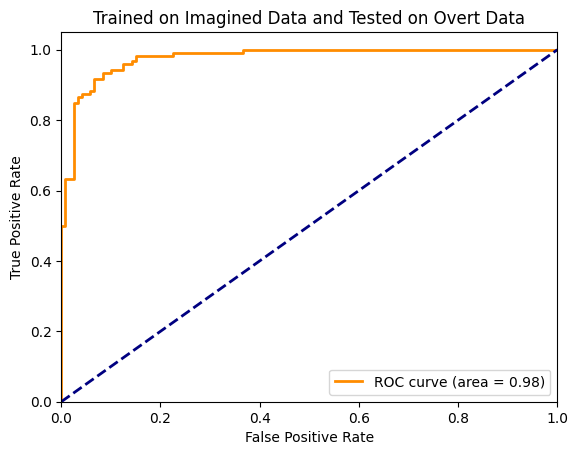

In [932]:
#train on Imagined data and test on Overt data
X_train = np.concatenate((Img_data_1.T, Img_data_2.T))
y_train = np.array([0]*len(Img_data_1.T) + [1]*len(Img_data_2.T))
X_test = np.concatenate((Overt_data_1.T, Overt_data_2.T))
y_test = np.array([0]*len(Overt_data_1.T) + [1]*len(Overt_data_2.T)) 

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

alphas = np.logspace(-2, 4, num=50)
    
test_accuracy, channel_weights, decision_statistics, best_alpha = cross_validation_one_level(X_train, y_train, X_test, y_test,alphas=alphas)

print("Accuracy:", test_accuracy)
print("Best Lambda:", best_alpha)

plot_roc_curve(y_test, decision_statistics, 'Trained on Imagined Data and Tested on Overt Data')

(204, 240)


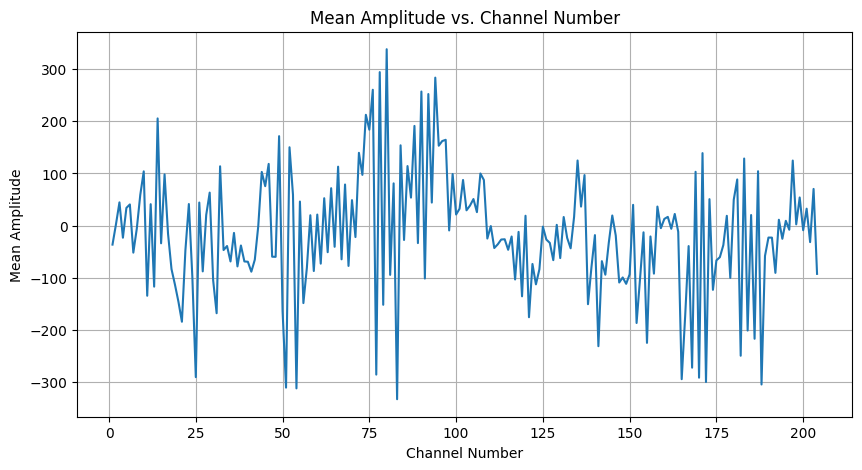

In [933]:
#read feaSubEOvert_1.csv file
data1 = pd.read_csv('data/raw/feaSubEImg_1.csv', header=None)
data2 = pd.read_csv('data/raw/feaSubEImg_2.csv', header=None)
concatenated_data = pd.concat([data1, data2], axis=1)
data = concatenated_data.values

#size of the data
print(data.shape)

# Calculate the mean across columns for each row
mean_amplitudes = np.mean(data, axis=1)

#find magnitude of mean amplitudes
channel_weights_magnitude = mean_amplitudes     

# Plot the mean amplitudes against the row numbers (channels)
row_numbers = np.arange(1, len(channel_weights_magnitude) + 1)
plt.figure(figsize=(10, 5))
plt.plot(row_numbers, channel_weights_magnitude)
plt.title('Mean Amplitude vs. Channel Number')
plt.xlabel('Channel Number')
plt.ylabel('Mean Amplitude')
plt.grid(True)
plt.show()



/var/folders/rt/wydyk1yn1096_jp1cjy1506m0000gn/T/ipykernel_49870/2049233593.py:31: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(c, label='Electrode Value')


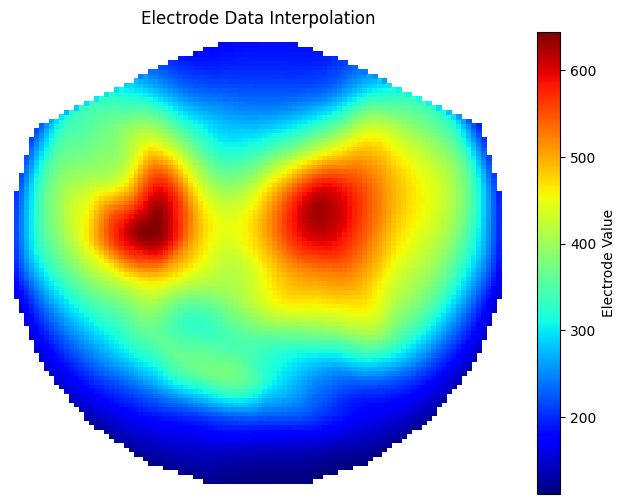

In [934]:
data_class1 = Img_data_1.values
data_class2 = Img_data_2.values
data_class1_overt = Overt_data_1.values

# Concatenate the data from both classes along the columns (axis=1)
concatenated_data = np.concatenate((data_class1, data_class2), axis=1)

# Calculate the magnitude
# Reshape the data to separate x and y components for each electrode
reshaped_data = concatenated_data.reshape(102, 2, -1)  # 102 electrodes, 2 components (x, y), all trials
magnitude_data = np.sqrt(np.sum(reshaped_data**2, axis=1))  # Calculate magnitude for each electrode

# Now, magnitude_data is a 102x240 array (102 electrodes, 240 trials)
# You can calculate the mean magnitude across all trials for each electrode
mean_magnitudes = np.mean(magnitude_data, axis=1)

values = mean_magnitudes
electrode_positions = SensorData.values

# Generate a grid over which to interpolate
# xi and yi define the resolution of the grid, adjust as necessary for your data's scale
grid_x, grid_y = np.mgrid[min(electrode_positions[:,0]):max(electrode_positions[:,0]):100j, 
                          min(electrode_positions[:,1]):max(electrode_positions[:,1]):100j]

# Interpolate the data to the grid using linear or cubic interpolation
zi = griddata(electrode_positions, values, (grid_x, grid_y), method='cubic')

# Create the plot using pcolor
plt.figure(figsize=(8, 6))
c = plt.pcolor(grid_x, grid_y, zi, cmap='jet', shading='auto')
plt.colorbar(c, label='Electrode Value')
plt.title('Electrode Data Interpolation')
plt.axis('equal')
plt.axis('off')
plt.show()


Accuracy: 0.8833333333333333
Best Lambda: 0.017575106248547922


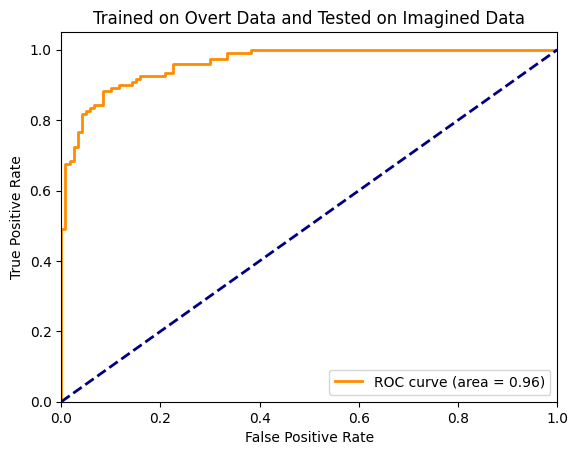

In [935]:
#train on Overt data and test on Imagined data
X_test = np.concatenate((Img_data_1.T, Img_data_2.T))
y_test = np.array([0]*len(Img_data_1.T) + [1]*len(Img_data_2.T))
X_train = np.concatenate((Overt_data_1.T, Overt_data_2.T))
y_train = np.array([0]*len(Overt_data_1.T) + [1]*len(Overt_data_2.T))

alphas = np.logspace(-2, 4, num=50)
    
test_accuracy, channel_weights, decision_statistics, best_alpha = cross_validation_one_level(X_train, y_train, X_test, y_test,alphas=alphas)

print("Accuracy:", test_accuracy)
print("Best Lambda:", best_alpha)

plot_roc_curve(y_test, decision_statistics, 'Trained on Overt Data and Tested on Imagined Data')